# 60/40 Portfolio Improvement Backtesting
## Testing Alternative Asset Class Additions

**Objective:** Test whether adding Infrastructure, Private Credit, and Real Assets improves the traditional 60/40 portfolio.

**Date:** February 2026

---

### Notebook Structure
1. **Setup & Installation**
2. **Data Download** (from yfinance)
3. **Data Processing & Quality Checks**
4. **Portfolio Construction**
5. **Performance Metrics Calculation**
6. **Visualization**
7. **Statistical Testing**
8. **Results & Conclusions**

---
## 1. Setup & Installation

In [ ]:
# Install required packages (run once)
# Uncomment the lines below if packages are not installed

# !pip install yfinance pandas numpy scipy matplotlib seaborn

In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

Libraries imported successfully!
pandas version: 3.0.0
numpy version: 2.4.2


---
## 2. Data Download

### 2.1 Define Tickers and Metadata

**Data Availability Summary:**

| Asset Class | ETF Proxy | Ticker | Available From | Limitation |
|-------------|-----------|--------|----------------|------------|
| US Equity | SPDR S&P 500 | SPY | 1993 | ✅ Good proxy |
| US Bonds | iShares Core Agg | AGG | 2003 | ✅ Good proxy |
| Infrastructure | iShares Global Infra | IGF | 2007 | ⚠️ Listed only (higher vol) |
| Private Credit | iShares High Yield | HYG | 2007 | ⚠️ Fixed rate, not floating |
| Private Credit | Invesco Senior Loan | BKLN | 2011 | ⚠️ Better proxy (floating) |
| Real Assets | SPDR Natural Resources | GNR | 2010 | ⚠️ Listed equities, not land |
| Timber | iShares Timber | WOOD | 2008 | ⚠️ Timber companies, not land |

**❌ NOT available on yfinance:** NCREIF Farmland/Timberland, Cliffwater Direct Lending, EDHECinfra

In [2]:
# Define configuration
START_DATE = "2000-01-01"  # Request early, actual data starts later
END_DATE = datetime.today().strftime('%Y-%m-%d')

print(f"Data request period: {START_DATE} to {END_DATE}")

Data request period: 2000-01-01 to 2026-02-05


In [3]:
# Define all tickers to download
TICKERS = {
    # CORE PORTFOLIO ASSETS
    'Equity': {
        'ticker': 'SPY',
        'name': 'SPDR S&P 500 ETF',
        'expense_ratio': 0.0945,
    },
    'Bonds': {
        'ticker': 'AGG',
        'name': 'iShares Core US Aggregate Bond ETF',
        'expense_ratio': 0.03,
    },
    
    # ALTERNATIVE ASSETS
    'Infrastructure': {
        'ticker': 'IGF',
        'name': 'iShares Global Infrastructure ETF',
        'expense_ratio': 0.40,
    },
    'Credit_HY': {
        'ticker': 'HYG',
        'name': 'iShares High Yield Corporate Bond ETF',
        'expense_ratio': 0.48,
    },
    'Credit_Loans': {
        'ticker': 'BKLN',
        'name': 'Invesco Senior Loan ETF',
        'expense_ratio': 0.65,
    },
    'RealAssets': {
        'ticker': 'GNR',
        'name': 'SPDR S&P Global Natural Resources ETF',
        'expense_ratio': 0.40,
    },
    'Timber': {
        'ticker': 'WOOD',
        'name': 'iShares Global Timber & Forestry ETF',
        'expense_ratio': 0.40,
    },
    
    # ADDITIONAL REFERENCE
    'REITs': {
        'ticker': 'VNQ',
        'name': 'Vanguard Real Estate ETF',
        'expense_ratio': 0.12,
    },
    'Commodities': {
        'ticker': 'DBC',
        'name': 'Invesco DB Commodity Index Fund',
        'expense_ratio': 0.85,
    },
    'Gold': {
        'ticker': 'GLD',
        'name': 'SPDR Gold Shares',
        'expense_ratio': 0.40,
    },
    'TBills': {
        'ticker': 'BIL',
        'name': 'SPDR Bloomberg 1-3 Month T-Bill ETF',
        'expense_ratio': 0.1356,
    },
}

print(f"Defined {len(TICKERS)} tickers for download")

Defined 11 tickers for download


### 2.2 Download Data from yfinance

In [4]:
def download_data(tickers_dict, start_date, end_date):
    """
    Download adjusted close prices for all tickers.
    
    Returns:
        pd.DataFrame: Daily adjusted close prices
    """
    # Extract ticker symbols
    ticker_list = [info['ticker'] for info in tickers_dict.values()]
    ticker_names = list(tickers_dict.keys())
    
    print(f"Downloading {len(ticker_list)} tickers...")
    print(f"Tickers: {ticker_list}")
    print()
    
    # Download all at once (faster)
    data = yf.download(
        ticker_list,
        start=start_date,
        end=end_date,
        auto_adjust=True,  # Adjust for splits and dividends
        progress=True
    )
    
    # Extract Close prices
    if isinstance(data.columns, pd.MultiIndex):
        prices = data['Close']
    else:
        prices = data[['Close']]
        prices.columns = ticker_list
    
    # Rename columns to asset class names
    ticker_to_name = {info['ticker']: name for name, info in tickers_dict.items()}
    prices.columns = [ticker_to_name.get(col, col) for col in prices.columns]
    
    return prices

# Download data
daily_prices = download_data(TICKERS, START_DATE, END_DATE)

print(f"\nDownloaded data shape: {daily_prices.shape}")
print(f"Date range: {daily_prices.index[0].strftime('%Y-%m-%d')} to {daily_prices.index[-1].strftime('%Y-%m-%d')}")

Tickers: ['SPY', 'AGG', 'IGF', 'HYG', 'BKLN', 'GNR', 'WOOD', 'VNQ', 'DBC', 'GLD', 'BIL']



[*********************100%***********************]  11 of 11 completed



Downloaded data shape: (6562, 11)
Date range: 2000-01-03 to 2026-02-04


In [5]:
# Preview the data
daily_prices.tail(10)

,Bonds,TBills,Credit_Loans,Commodities,Gold,RealAssets,Credit_HY,Infrastructure,Equity,REITs,Timber
Date,,,,,,,,,,,
2026-01-22,99.6954,91.2863,20.9000,23.7400,451.7900,67.8200,80.7807,62.8600,688.9800,90.3600,76.7700
2026-01-23,99.7851,91.3162,20.8800,24.1800,458.0000,69.0800,80.7409,63.0400,689.2300,90.5400,76.9900
2026-01-26,99.9346,91.3162,20.8400,24.2900,464.7000,69.3600,80.7807,63.4000,692.7300,90.4200,76.8300
2026-01-27,99.8648,91.3261,20.8200,24.6200,476.1000,70.3200,80.7708,64.4300,695.4900,90.3900,76.9400
2026-01-28,99.8249,91.3361,20.8000,24.9400,494.5600,70.9700,80.6414,64.3500,695.4200,89.4600,76.1800
2026-01-29,99.8249,91.3561,20.7300,25.3000,495.9000,71.0400,80.6314,64.7900,694.0400,90.7100,75.6700
2026-01-30,99.8050,91.3760,20.7400,24.4300,444.9500,68.1500,80.7210,64.4100,691.9700,90.8000,74.6800
2026-02-02,99.6900,91.3900,20.7700,23.5400,427.1300,68.1800,80.7700,63.9600,695.4100,89.8600,74.2000
2026-02-03,99.7000,91.3900,20.7100,24.1500,454.2900,70.2700,80.7200,64.8600,689.5300,89.6600,75.1000


### 2.3 Convert to Monthly Returns

In [6]:
def calculate_monthly_returns(daily_prices):
    """
    Convert daily prices to monthly log returns.
    
    Returns:
        pd.DataFrame: Monthly log returns
    """
    # Resample to month-end prices
    monthly_prices = daily_prices.resample('ME').last()
    
    # Calculate log returns
    monthly_returns = np.log(monthly_prices / monthly_prices.shift(1))
    
    # Drop first row (NaN)
    monthly_returns = monthly_returns.dropna(how='all')
    
    return monthly_returns

# Calculate monthly returns
monthly_returns = calculate_monthly_returns(daily_prices)

print(f"Monthly returns shape: {monthly_returns.shape}")
print(f"Date range: {monthly_returns.index[0].strftime('%Y-%m')} to {monthly_returns.index[-1].strftime('%Y-%m')}")

Monthly returns shape: (313, 11)
Date range: 2000-02 to 2026-02


In [7]:
# Preview monthly returns
monthly_returns.tail(10)

,Bonds,TBills,Credit_Loans,Commodities,Gold,RealAssets,Credit_HY,Infrastructure,Equity,REITs,Timber
Date,,,,,,,,,,,
2025-05-31,-0.0061,0.0036,0.0146,0.0150,-0.0006,0.0351,0.0174,0.0452,0.0609,0.0111,0.0197
2025-06-30,0.0144,0.0033,0.0084,0.0436,0.0040,0.0356,0.0182,0.0201,0.0501,0.0069,0.0026
2025-07-31,-0.0026,0.0036,0.0062,0.0289,-0.0062,0.0051,0.0014,-0.0020,0.0228,0.0009,-0.0335
2025-08-31,0.0118,0.0037,0.0054,-0.0107,0.0487,0.0631,0.0110,0.0213,0.0203,0.0342,0.0689
2025-09-30,0.0112,0.0033,0.0064,0.0143,0.1112,0.0194,0.0088,0.0127,0.0350,0.0006,-0.0347
2025-10-31,0.0061,0.0035,0.0043,0.0154,0.0350,-0.0073,-0.0001,-0.0020,0.0236,-0.0248,-0.0563
2025-11-30,0.0060,0.0029,0.0067,0.0078,0.0523,0.0381,0.0074,0.0332,0.0019,0.0239,0.0142
2025-12-31,-0.0028,0.0033,0.0087,0.0023,0.0215,0.0332,0.0049,-0.0112,0.0008,-0.0226,0.0377
2026-01-31,0.0025,0.0030,-0.0073,0.0885,0.1158,0.0923,0.0061,0.0485,0.0146,0.0258,0.0364


---
## 3. Data Processing & Quality Checks

### 3.1 Data Availability Summary

In [8]:
def data_quality_summary(returns_df):
    """
    Generate data quality summary statistics.
    """
    summary = pd.DataFrame({
        'First_Date': returns_df.apply(lambda x: x.first_valid_index()),
        'Last_Date': returns_df.apply(lambda x: x.last_valid_index()),
        'Total_Months': returns_df.count(),
        'Missing': returns_df.isna().sum(),
        'Ann_Return_%': (returns_df.mean() * 12 * 100).round(2),
        'Ann_Vol_%': (returns_df.std() * np.sqrt(12) * 100).round(2),
        'Min_%': (returns_df.min() * 100).round(2),
        'Max_%': (returns_df.max() * 100).round(2),
    })
    
    # Format dates
    summary['First_Date'] = summary['First_Date'].dt.strftime('%Y-%m')
    summary['Last_Date'] = summary['Last_Date'].dt.strftime('%Y-%m')
    
    return summary

# Generate summary
quality_summary = data_quality_summary(monthly_returns)
quality_summary

,First_Date,Last_Date,Total_Months,Missing,Ann_Return_%,Ann_Vol_%,Min_%,Max_%
Bonds,2003-10,2026-02,269,44,3.0500,4.4100,-4.2300,6.4500
TBills,2007-06,2026-02,225,88,1.3000,0.5500,-0.2300,0.5100
Credit_Loans,2011-04,2026-02,179,134,3.6500,4.7200,-6.7600,4.7500
Commodities,2006-03,2026-02,240,73,1.3500,18.7000,-28.8800,15.0700
Gold,2004-12,2026-02,255,58,10.8600,16.6900,-17.6000,12.0300
RealAssets,2010-10,2026-02,185,128,5.1600,19.6500,-21.1000,15.6000
Credit_HY,2007-05,2026-02,226,87,4.7900,10.2600,-12.1600,15.5000
Infrastructure,2008-01,2026-02,218,95,4.6000,17.0000,-25.6600,13.9900
Equity,2000-02,2026-02,313,0,7.8800,15.1700,-18.0500,11.9500
REITs,2004-10,2026-02,257,56,7.0600,22.1100,-38.1700,26.7600


### 3.2 Identify Common Analysis Period

In [9]:
# Define asset groups for different analyses
ANALYSIS_CONFIGS = {
    'Full_Analysis': ['Equity', 'Bonds', 'Infrastructure', 'Credit_HY', 'RealAssets'],
    'With_Floating_Credit': ['Equity', 'Bonds', 'Infrastructure', 'Credit_Loans', 'RealAssets'],
    'Infra_Only': ['Equity', 'Bonds', 'Infrastructure'],
    'Credit_Only': ['Equity', 'Bonds', 'Credit_HY'],
    'Core_Only': ['Equity', 'Bonds'],
}

def find_common_period(returns_df, columns):
    """
    Find the common date range where all specified columns have data.
    """
    available_cols = [c for c in columns if c in returns_df.columns]
    missing_cols = [c for c in columns if c not in returns_df.columns]
    
    if missing_cols:
        return None, None, 0, missing_cols
    
    subset = returns_df[available_cols].dropna()
    
    if subset.empty:
        return None, None, 0, []
    
    return subset.index[0], subset.index[-1], len(subset), []

# Check each configuration
print("Available Analysis Periods:\n")
print(f"{'Configuration':<25} {'Start':<10} {'End':<10} {'Months':<8} {'Status'}")
print("-" * 70)

for config_name, columns in ANALYSIS_CONFIGS.items():
    start, end, months, missing = find_common_period(monthly_returns, columns)
    if missing:
        print(f"{config_name:<25} {'N/A':<10} {'N/A':<10} {0:<8} Missing: {missing}")
    elif start is not None:
        print(f"{config_name:<25} {start.strftime('%Y-%m'):<10} {end.strftime('%Y-%m'):<10} {months:<8} ✅ Ready")
    else:
        print(f"{config_name:<25} {'N/A':<10} {'N/A':<10} {0:<8} ❌ No data")

Available Analysis Periods:

Configuration             Start      End        Months   Status
----------------------------------------------------------------------
Full_Analysis             2010-10    2026-02    185      ✅ Ready
With_Floating_Credit      2011-04    2026-02    179      ✅ Ready
Infra_Only                2008-01    2026-02    218      ✅ Ready
Credit_Only               2007-05    2026-02    226      ✅ Ready
Core_Only                 2003-10    2026-02    269      ✅ Ready


### 3.3 Create Analysis Dataset

We'll use the **Full_Analysis** configuration with the common period where all assets have data.

In [10]:
# Select primary assets for analysis
PRIMARY_ASSETS = ['Equity', 'Bonds', 'Infrastructure', 'Credit_HY', 'RealAssets']

# Filter to common period
analysis_returns = monthly_returns[PRIMARY_ASSETS].dropna()

print(f"Analysis dataset:")
print(f"  Assets: {list(analysis_returns.columns)}")
print(f"  Period: {analysis_returns.index[0].strftime('%Y-%m')} to {analysis_returns.index[-1].strftime('%Y-%m')}")
print(f"  Months: {len(analysis_returns)}")

Analysis dataset:
  Assets: ['Equity', 'Bonds', 'Infrastructure', 'Credit_HY', 'RealAssets']
  Period: 2010-10 to 2026-02
  Months: 185


In [11]:
# Also get risk-free rate for Sharpe ratio calculations
if 'TBills' in monthly_returns.columns:
    rf_returns = monthly_returns['TBills'].reindex(analysis_returns.index)
    # Fill missing with 0 (conservative assumption)
    rf_returns = rf_returns.fillna(0)
    print(f"Risk-free rate data: {rf_returns.count()} months")
else:
    # Use constant 2% annual rate if no T-bill data
    rf_returns = pd.Series(0.02/12, index=analysis_returns.index)
    print("Using constant 2% annual risk-free rate (T-bill data not available)")

Risk-free rate data: 185 months


---
## 4. Portfolio Construction

### 4.1 Define Portfolio Weights

In [12]:
# Portfolio definitions
# Order: [Equity, Bonds, Infrastructure, Credit, RealAssets]

PORTFOLIOS = {
    'A_Baseline_60_40': {
        'weights': [0.60, 0.40, 0.00, 0.00, 0.00],
        'description': 'Traditional 60/40 portfolio',
        'color': 'black',
    },
    'B_Plus_Infra': {
        'weights': [0.60, 0.30, 0.10, 0.00, 0.00],
        'description': '60/30/10 with Infrastructure',
        'color': 'blue',
    },
    'C_Plus_Credit': {
        'weights': [0.60, 0.30, 0.00, 0.10, 0.00],
        'description': '60/30/10 with Private Credit',
        'color': 'green',
    },
    'D_Plus_RealAssets': {
        'weights': [0.60, 0.30, 0.00, 0.00, 0.10],
        'description': '60/30/10 with Real Assets',
        'color': 'orange',
    },
    'E_Infra_Credit': {
        'weights': [0.60, 0.25, 0.08, 0.07, 0.00],
        'description': '60/25/8/7 Infrastructure + Credit',
        'color': 'purple',
    },
    'F_All_Three': {
        'weights': [0.60, 0.22, 0.06, 0.06, 0.06],
        'description': '60/22/6/6/6 All Three Alternatives',
        'color': 'red',
    },
    'G_Aggressive': {
        'weights': [0.55, 0.20, 0.10, 0.08, 0.07],
        'description': '55/20/10/8/7 Aggressive Alternatives',
        'color': 'darkred',
    },
}

# Display portfolio allocations
print("Portfolio Allocations:\n")
print(f"{'Portfolio':<20} {'Equity':>8} {'Bonds':>8} {'Infra':>8} {'Credit':>8} {'Real':>8} {'Total':>8}")
print("-" * 80)

for name, config in PORTFOLIOS.items():
    w = config['weights']
    total = sum(w)
    print(f"{name:<20} {w[0]*100:>7.0f}% {w[1]*100:>7.0f}% {w[2]*100:>7.0f}% {w[3]*100:>7.0f}% {w[4]*100:>7.0f}% {total*100:>7.0f}%")

Portfolio Allocations:

Portfolio              Equity    Bonds    Infra   Credit     Real    Total
--------------------------------------------------------------------------------
A_Baseline_60_40          60%      40%       0%       0%       0%     100%
B_Plus_Infra              60%      30%      10%       0%       0%     100%
C_Plus_Credit             60%      30%       0%      10%       0%     100%
D_Plus_RealAssets         60%      30%       0%       0%      10%     100%
E_Infra_Credit            60%      25%       8%       7%       0%     100%
F_All_Three               60%      22%       6%       6%       6%     100%
G_Aggressive              55%      20%      10%       8%       7%     100%


### 4.2 Calculate Portfolio Returns

In [13]:
def calculate_portfolio_returns(returns_df, weights):
    """
    Calculate portfolio returns given asset returns and weights.
    Assumes monthly rebalancing to target weights.
    
    Parameters:
        returns_df: DataFrame with asset returns
        weights: list of weights [Equity, Bonds, Infra, Credit, RealAssets]
        
    Returns:
        pd.Series: Portfolio returns
    """
    weights_array = np.array(weights)
    portfolio_returns = (returns_df * weights_array).sum(axis=1)
    return portfolio_returns

# Calculate returns for all portfolios
portfolio_returns = pd.DataFrame()

for name, config in PORTFOLIOS.items():
    portfolio_returns[name] = calculate_portfolio_returns(analysis_returns, config['weights'])

print(f"Calculated returns for {len(PORTFOLIOS)} portfolios")
print(f"Period: {portfolio_returns.index[0].strftime('%Y-%m')} to {portfolio_returns.index[-1].strftime('%Y-%m')}")
print(f"Months: {len(portfolio_returns)}")

Calculated returns for 7 portfolios
Period: 2010-10 to 2026-02
Months: 185


In [14]:
# Preview portfolio returns
portfolio_returns.tail(10)

,A_Baseline_60_40,B_Plus_Infra,C_Plus_Credit,D_Plus_RealAssets,E_Infra_Credit,F_All_Three,G_Aggressive
Date,,,,,,,
2025-05-31,0.0341,0.0393,0.0365,0.0383,0.0399,0.0411,0.0407
2025-06-30,0.0358,0.0364,0.0362,0.0380,0.0366,0.0377,0.0364
2025-07-31,0.0126,0.0127,0.0130,0.0134,0.0129,0.0133,0.0123
2025-08-31,0.0169,0.0179,0.0168,0.0220,0.0176,0.0205,0.0210
2025-09-30,0.0255,0.0256,0.0252,0.0263,0.0254,0.0259,0.0248
2025-10-31,0.0166,0.0158,0.0160,0.0152,0.0155,0.0149,0.0135
2025-11-30,0.0036,0.0063,0.0037,0.0068,0.0059,0.0072,0.0089
2025-12-31,-0.0006,-0.0015,0.0001,0.0030,-0.0008,0.0015,0.0015
2026-01-31,0.0098,0.0144,0.0101,0.0188,0.0137,0.0181,0.0203


### 4.3 Calculate Cumulative Wealth

In [15]:
# Calculate cumulative wealth (starting with $100)
initial_wealth = 100
cumulative_wealth = initial_wealth * (1 + portfolio_returns).cumprod()

print("Final Wealth (starting with $100):\n")
final_wealth = cumulative_wealth.iloc[-1].sort_values(ascending=False)
for name, value in final_wealth.items():
    print(f"  {name:<20}: ${value:,.2f}")

Final Wealth (starting with $100):

  E_Infra_Credit      : $399.56
  F_All_Three         : $398.90
  B_Plus_Infra        : $394.88
  C_Plus_Credit       : $383.31
  G_Aggressive        : $382.52
  D_Plus_RealAssets   : $379.62
  A_Baseline_60_40    : $369.75


---
## 5. Performance Metrics Calculation

### 5.1 Define Metric Functions

In [16]:
def annualized_return(returns):
    """Calculate annualized return from monthly returns."""
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / 12
    return (1 + total_return) ** (1 / n_years) - 1

def annualized_volatility(returns):
    """Calculate annualized volatility from monthly returns."""
    return returns.std() * np.sqrt(12)

def sharpe_ratio(returns, rf_returns):
    """Calculate Sharpe ratio."""
    excess_returns = returns - rf_returns
    if excess_returns.std() == 0:
        return 0
    return (excess_returns.mean() * 12) / (excess_returns.std() * np.sqrt(12))

def sortino_ratio(returns, rf_returns, target=0):
    """Calculate Sortino ratio (penalizes only downside volatility)."""
    excess_returns = returns - rf_returns
    downside_returns = excess_returns[excess_returns < target]
    if len(downside_returns) == 0 or downside_returns.std() == 0:
        return np.nan
    downside_std = downside_returns.std() * np.sqrt(12)
    return (excess_returns.mean() * 12) / downside_std

def max_drawdown(returns):
    """Calculate maximum drawdown."""
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdowns = cumulative / rolling_max - 1
    return drawdowns.min()

def calmar_ratio(returns):
    """Calculate Calmar ratio (return / max drawdown)."""
    ann_ret = annualized_return(returns)
    mdd = abs(max_drawdown(returns))
    if mdd == 0:
        return np.nan
    return ann_ret / mdd

def var_95(returns):
    """Calculate 95% Value at Risk (monthly)."""
    return returns.quantile(0.05)

def cvar_95(returns):
    """Calculate 95% Conditional VaR (Expected Shortfall)."""
    var = var_95(returns)
    return returns[returns <= var].mean()

print("Metric functions defined successfully!")

Metric functions defined successfully!


### 5.2 Calculate All Metrics

In [17]:
def calculate_all_metrics(portfolio_returns, rf_returns):
    """
    Calculate comprehensive metrics for all portfolios.
    """
    metrics = {}
    
    for col in portfolio_returns.columns:
        returns = portfolio_returns[col]
        rf = rf_returns.reindex(returns.index).fillna(0)
        
        metrics[col] = {
            'Ann_Return_%': annualized_return(returns) * 100,
            'Ann_Volatility_%': annualized_volatility(returns) * 100,
            'Sharpe_Ratio': sharpe_ratio(returns, rf),
            'Sortino_Ratio': sortino_ratio(returns, rf),
            'Max_Drawdown_%': max_drawdown(returns) * 100,
            'Calmar_Ratio': calmar_ratio(returns),
            'VaR_95_%': var_95(returns) * 100,
            'CVaR_95_%': cvar_95(returns) * 100,
            'Total_Return_%': ((1 + returns).prod() - 1) * 100,
            'Positive_Months_%': (returns > 0).mean() * 100,
        }
    
    return pd.DataFrame(metrics).T

# Calculate metrics
metrics_df = calculate_all_metrics(portfolio_returns, rf_returns)

# Round for display
metrics_display = metrics_df.round(2)
metrics_display

,Ann_Return_%,Ann_Volatility_%,Sharpe_Ratio,Sortino_Ratio,Max_Drawdown_%,Calmar_Ratio,VaR_95_%,CVaR_95_%,Total_Return_%,Positive_Months_%
A_Baseline_60_40,8.8500,9.0200,0.8400,1.1100,-21.1300,0.4200,-3.9500,-5.4200,269.7500,68.6500
B_Plus_Infra,9.3200,9.9900,0.8100,1.0700,-20.9000,0.4500,-4.2000,-6.1400,294.8800,67.5700
C_Plus_Credit,9.1100,9.4400,0.8300,1.1000,-21.2600,0.4300,-4.0200,-5.7400,283.3100,68.6500
D_Plus_RealAssets,9.0400,10.3200,0.7700,1.0300,-20.5500,0.4400,-4.5500,-6.4500,279.6200,67.5700
E_Infra_Credit,9.4000,10.0900,0.8100,1.0700,-21.0400,0.4500,-4.3000,-6.2300,299.5600,68.1100
F_All_Three,9.3900,10.6400,0.7800,1.0200,-20.7300,0.4500,-4.6300,-6.7000,298.9000,67.5700
G_Aggressive,9.0900,10.7000,0.7500,0.9800,-20.0600,0.4500,-4.6100,-6.8100,282.5200,67.0300


### 5.3 Calculate Improvement vs Baseline

In [18]:
# Calculate improvement vs baseline (Portfolio A)
baseline = metrics_df.loc['A_Baseline_60_40']

improvement_df = metrics_df.copy()
improvement_df['Return_Diff'] = metrics_df['Ann_Return_%'] - baseline['Ann_Return_%']
improvement_df['Sharpe_Diff'] = metrics_df['Sharpe_Ratio'] - baseline['Sharpe_Ratio']
improvement_df['MaxDD_Diff'] = metrics_df['Max_Drawdown_%'] - baseline['Max_Drawdown_%']

print("Improvement vs 60/40 Baseline:\n")
print(improvement_df[['Ann_Return_%', 'Return_Diff', 'Sharpe_Ratio', 'Sharpe_Diff', 'Max_Drawdown_%', 'MaxDD_Diff']].round(2))

Improvement vs 60/40 Baseline:

                   Ann_Return_%  Return_Diff  Sharpe_Ratio  Sharpe_Diff  \
A_Baseline_60_40         8.8500       0.0000        0.8400       0.0000   
B_Plus_Infra             9.3200       0.4700        0.8100      -0.0300   
C_Plus_Credit            9.1100       0.2500        0.8300      -0.0100   
D_Plus_RealAssets        9.0400       0.1900        0.7700      -0.0800   
E_Infra_Credit           9.4000       0.5500        0.8100      -0.0300   
F_All_Three              9.3900       0.5400        0.7800      -0.0700   
G_Aggressive             9.0900       0.2400        0.7500      -0.1000   

                   Max_Drawdown_%  MaxDD_Diff  
A_Baseline_60_40         -21.1300      0.0000  
B_Plus_Infra             -20.9000      0.2300  
C_Plus_Credit            -21.2600     -0.1400  
D_Plus_RealAssets        -20.5500      0.5800  
E_Infra_Credit           -21.0400      0.0900  
F_All_Three              -20.7300      0.4000  
G_Aggressive             -20.06

### 5.4 Correlation Analysis

In [19]:
# Calculate correlation matrix for underlying assets
asset_correlation = analysis_returns.corr()

print("Asset Class Correlation Matrix:\n")
print(asset_correlation.round(2))

Asset Class Correlation Matrix:

                Equity  Bonds  Infrastructure  Credit_HY  RealAssets
Equity          1.0000 0.2900          0.7600     0.7900      0.7300
Bonds           0.2900 1.0000          0.3800     0.4700      0.1200
Infrastructure  0.7600 0.3800          1.0000     0.7900      0.7800
Credit_HY       0.7900 0.4700          0.7900     1.0000      0.7300
RealAssets      0.7300 0.1200          0.7800     0.7300      1.0000


---
## 6. Visualization

### 6.1 Cumulative Wealth Chart

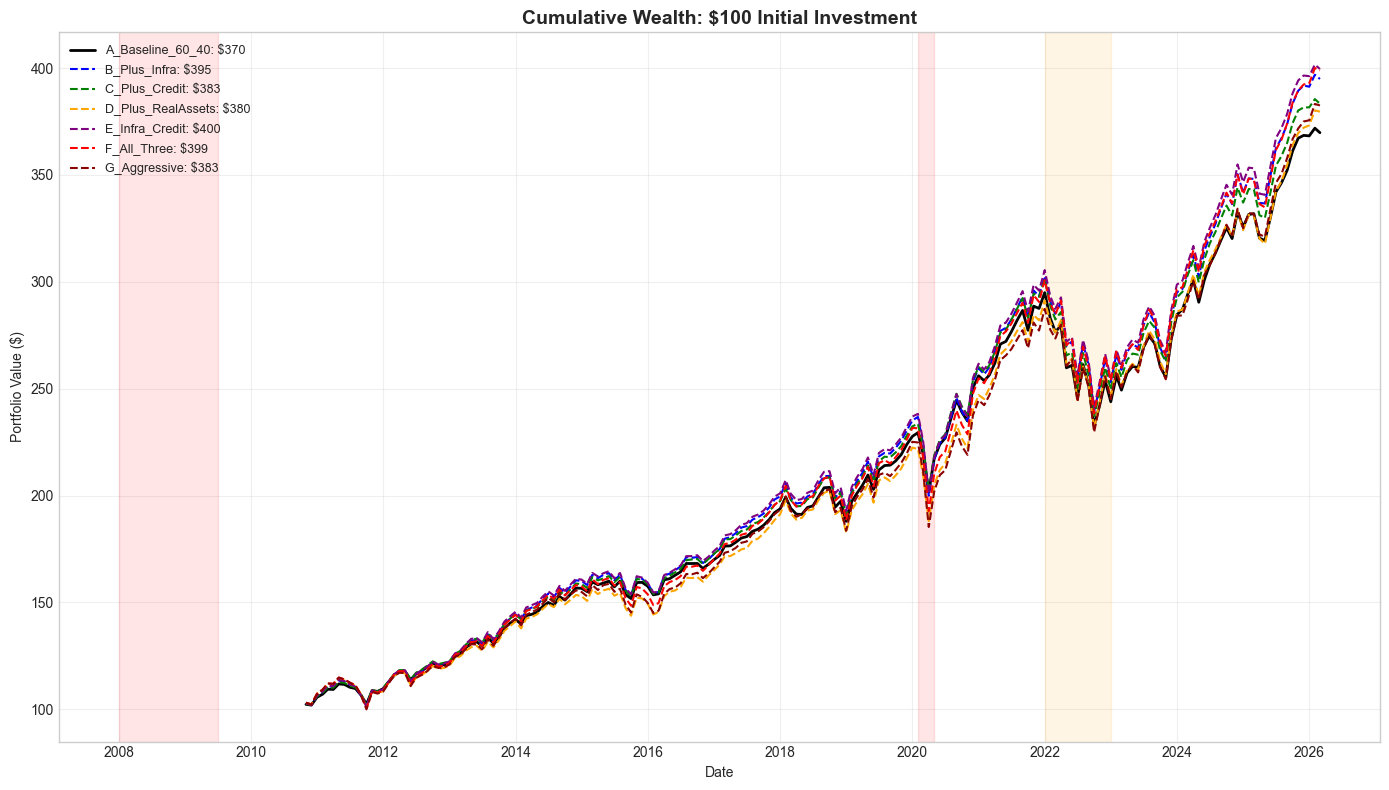

In [20]:
# Plot cumulative wealth
fig, ax = plt.subplots(figsize=(14, 8))

for name, config in PORTFOLIOS.items():
    ax.plot(cumulative_wealth.index, cumulative_wealth[name], 
            label=f"{name}: ${cumulative_wealth[name].iloc[-1]:,.0f}",
            color=config['color'],
            linewidth=2 if name == 'A_Baseline_60_40' else 1.5,
            linestyle='-' if name == 'A_Baseline_60_40' else '--')

ax.set_title('Cumulative Wealth: $100 Initial Investment', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value ($)')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

# Add recession shading for 2008-2009 and 2020
ax.axvspan('2008-01-01', '2009-06-30', alpha=0.1, color='red', label='GFC')
ax.axvspan('2020-02-01', '2020-04-30', alpha=0.1, color='red', label='COVID')
ax.axvspan('2022-01-01', '2022-12-31', alpha=0.1, color='orange', label='2022 Inflation')

plt.tight_layout()
plt.show()

### 6.2 Drawdown Chart

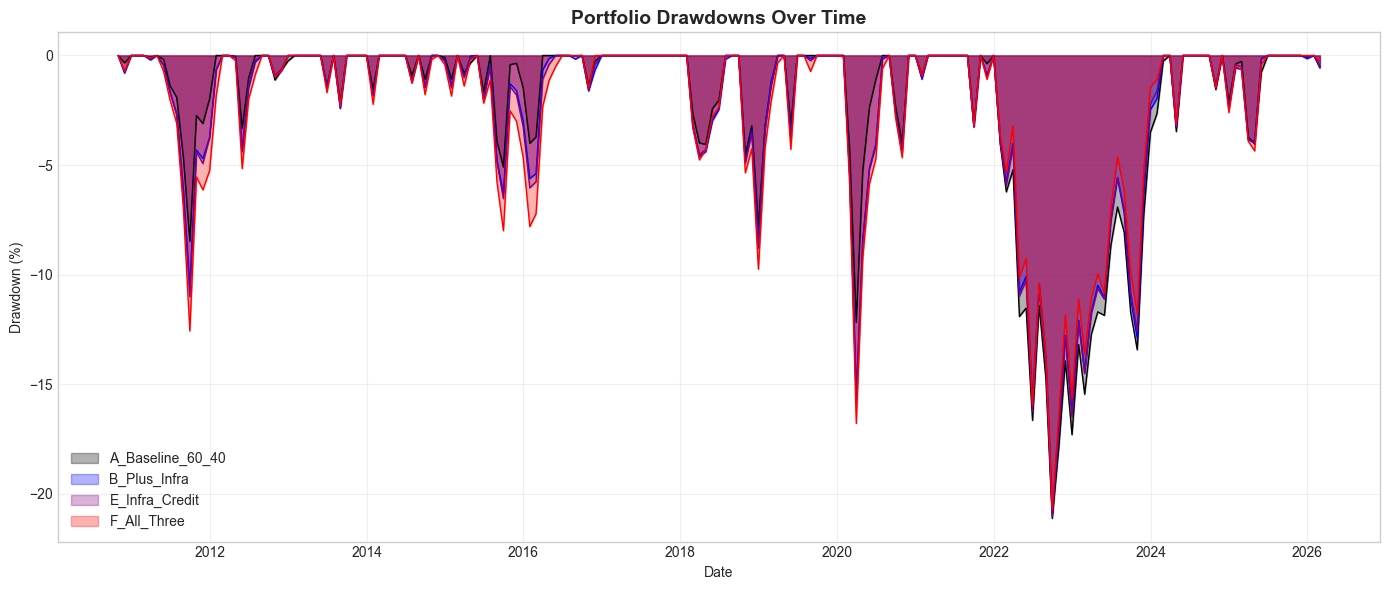

In [21]:
def calculate_drawdown_series(returns):
    """Calculate drawdown series."""
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdowns = cumulative / rolling_max - 1
    return drawdowns

# Calculate drawdowns for all portfolios
drawdowns = pd.DataFrame()
for col in portfolio_returns.columns:
    drawdowns[col] = calculate_drawdown_series(portfolio_returns[col])

# Plot drawdowns
fig, ax = plt.subplots(figsize=(14, 6))

# Plot only key portfolios for clarity
key_portfolios = ['A_Baseline_60_40', 'B_Plus_Infra', 'E_Infra_Credit', 'F_All_Three']

for name in key_portfolios:
    config = PORTFOLIOS[name]
    ax.fill_between(drawdowns.index, drawdowns[name] * 100, 0,
                    alpha=0.3, label=name, color=config['color'])
    ax.plot(drawdowns.index, drawdowns[name] * 100, color=config['color'], linewidth=1)

ax.set_title('Portfolio Drawdowns Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown (%)')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.3 Risk-Return Scatter Plot

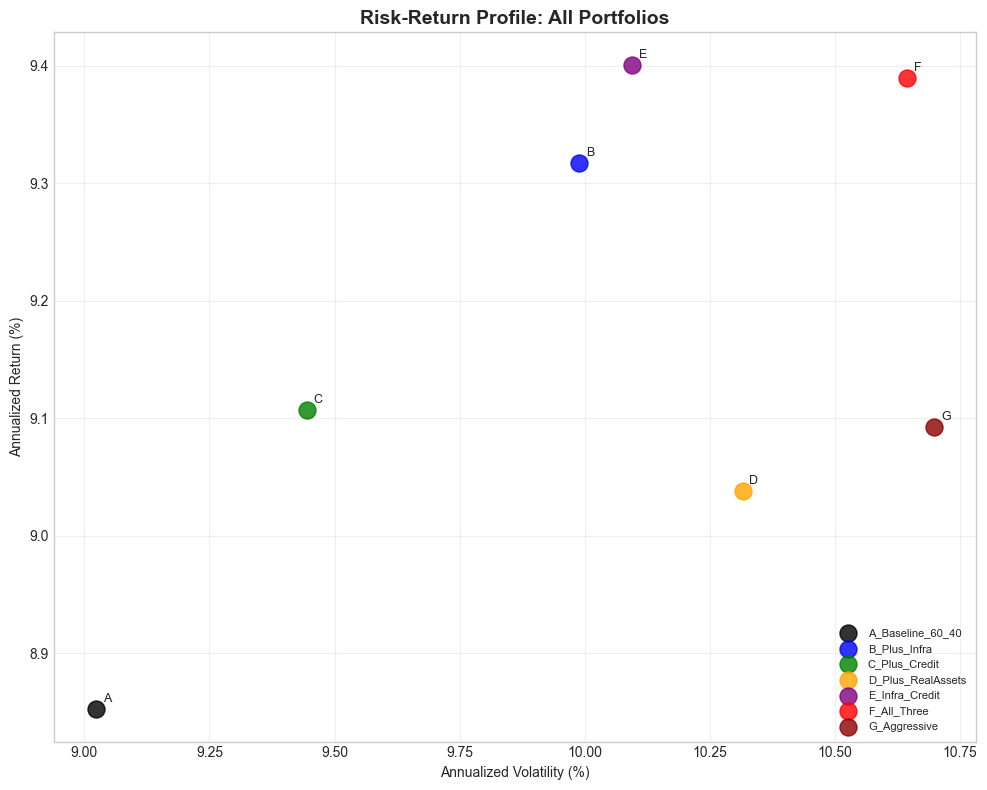

In [22]:
# Risk-Return scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

for name, config in PORTFOLIOS.items():
    x = metrics_df.loc[name, 'Ann_Volatility_%']
    y = metrics_df.loc[name, 'Ann_Return_%']
    ax.scatter(x, y, s=150, color=config['color'], label=name, alpha=0.8)
    ax.annotate(name.split('_')[0], (x, y), textcoords="offset points", 
                xytext=(5, 5), fontsize=9)

ax.set_title('Risk-Return Profile: All Portfolios', fontsize=14, fontweight='bold')
ax.set_xlabel('Annualized Volatility (%)')
ax.set_ylabel('Annualized Return (%)')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.4 Correlation Heatmap

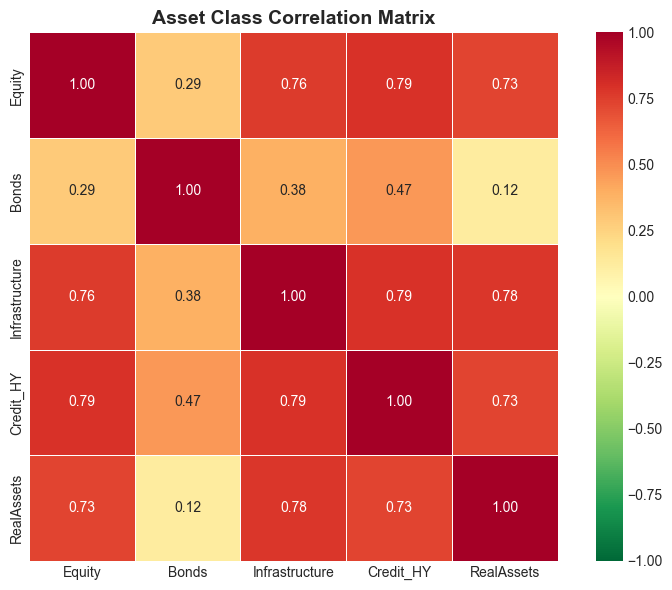

In [23]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(asset_correlation, annot=True, cmap='RdYlGn_r', center=0,
            fmt='.2f', square=True, linewidths=0.5, ax=ax,
            vmin=-1, vmax=1)

ax.set_title('Asset Class Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 6.5 Performance Metrics Bar Chart

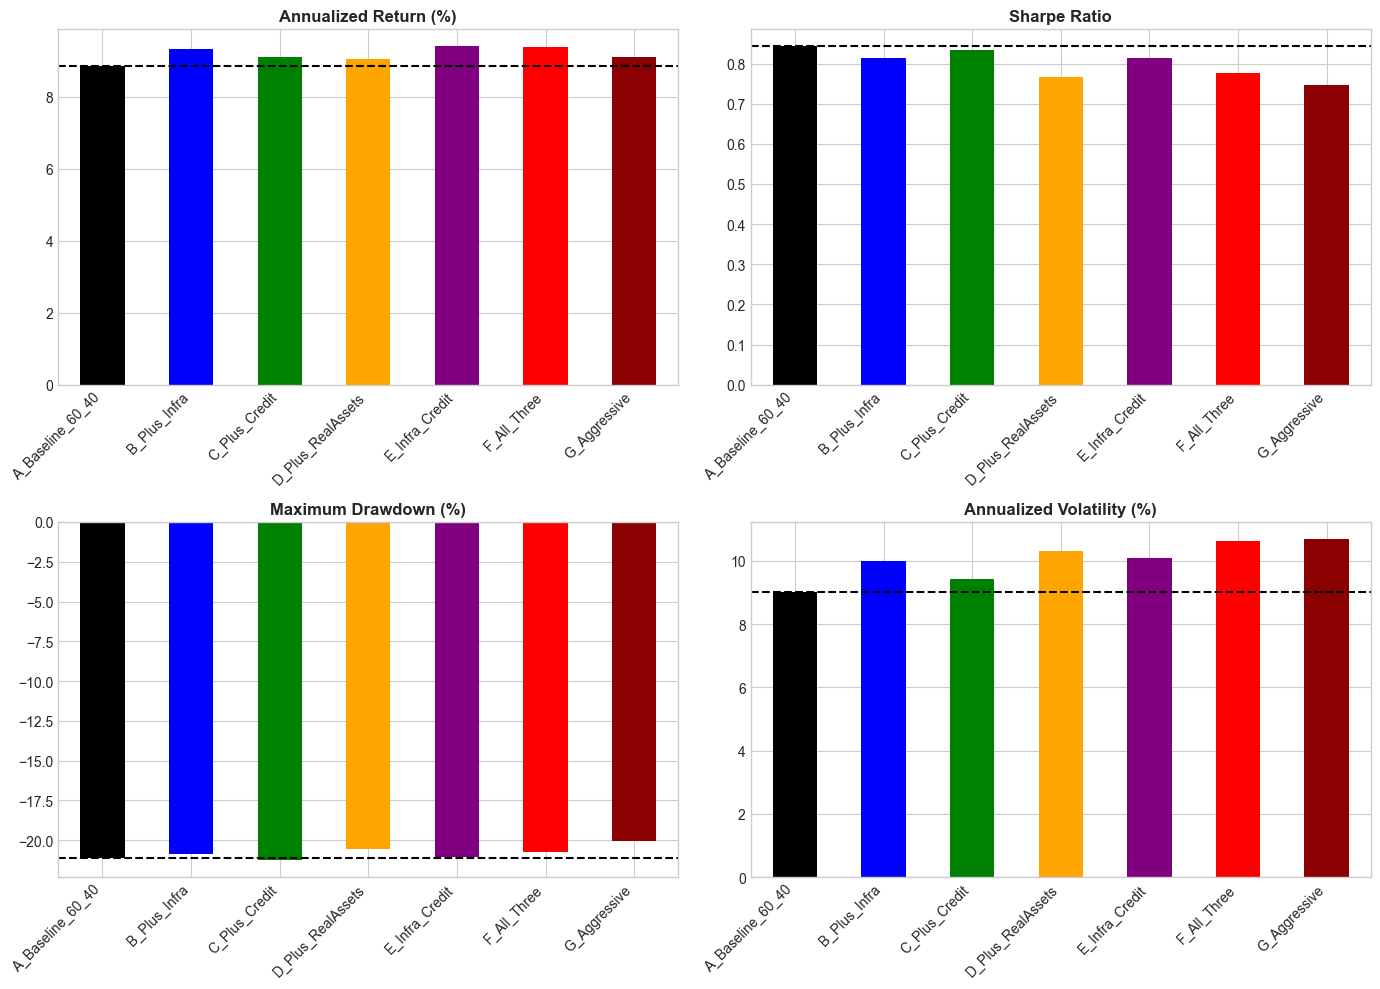

In [24]:
# Bar chart comparing key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = [PORTFOLIOS[name]['color'] for name in metrics_df.index]

# Annualized Return
ax1 = axes[0, 0]
metrics_df['Ann_Return_%'].plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Annualized Return (%)', fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.axhline(y=metrics_df.loc['A_Baseline_60_40', 'Ann_Return_%'], color='black', linestyle='--', label='Baseline')

# Sharpe Ratio
ax2 = axes[0, 1]
metrics_df['Sharpe_Ratio'].plot(kind='bar', ax=ax2, color=colors)
ax2.set_title('Sharpe Ratio', fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.axhline(y=metrics_df.loc['A_Baseline_60_40', 'Sharpe_Ratio'], color='black', linestyle='--', label='Baseline')

# Max Drawdown
ax3 = axes[1, 0]
metrics_df['Max_Drawdown_%'].plot(kind='bar', ax=ax3, color=colors)
ax3.set_title('Maximum Drawdown (%)', fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.axhline(y=metrics_df.loc['A_Baseline_60_40', 'Max_Drawdown_%'], color='black', linestyle='--', label='Baseline')

# Volatility
ax4 = axes[1, 1]
metrics_df['Ann_Volatility_%'].plot(kind='bar', ax=ax4, color=colors)
ax4.set_title('Annualized Volatility (%)', fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.axhline(y=metrics_df.loc['A_Baseline_60_40', 'Ann_Volatility_%'], color='black', linestyle='--', label='Baseline')

plt.tight_layout()
plt.show()

---
## 7. Statistical Testing

### 7.1 Paired T-Test for Return Improvement

In [25]:
def test_return_improvement(portfolio_returns, baseline_col='A_Baseline_60_40'):
    """
    Perform paired t-test to check if portfolios significantly outperform baseline.
    """
    baseline = portfolio_returns[baseline_col]
    results = []
    
    for col in portfolio_returns.columns:
        if col == baseline_col:
            continue
            
        portfolio = portfolio_returns[col]
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(portfolio, baseline)
        
        # Calculate mean difference
        mean_diff = (portfolio - baseline).mean() * 12 * 100  # Annualized %
        
        results.append({
            'Portfolio': col,
            'Mean_Diff_%': mean_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'Significant_5%': 'Yes' if p_value < 0.05 else 'No',
            'Significant_10%': 'Yes' if p_value < 0.10 else 'No',
        })
    
    return pd.DataFrame(results)

# Run t-tests
ttest_results = test_return_improvement(portfolio_returns)
print("Paired T-Test Results (vs 60/40 Baseline):\n")
print(ttest_results.round(4))

Paired T-Test Results (vs 60/40 Baseline):

           Portfolio  Mean_Diff_%  t_statistic  p_value Significant_5%  \
0       B_Plus_Infra       0.5224       1.5307   0.1276             No   
1      C_Plus_Credit       0.2744       1.6244   0.1060             No   
2  D_Plus_RealAssets       0.2975       0.5957   0.5521             No   
3     E_Infra_Credit       0.6100       1.6587   0.0989             No   
4        F_All_Three       0.6566       1.1700   0.2435             No   
5       G_Aggressive       0.3891       0.6110   0.5420             No   

  Significant_10%  
0              No  
1              No  
2              No  
3             Yes  
4              No  
5              No  


### 7.2 Bootstrap Confidence Intervals

In [26]:
def bootstrap_sharpe_ratio(returns, rf_returns, n_bootstrap=5000, confidence=0.95):
    """
    Calculate bootstrap confidence interval for Sharpe ratio.
    """
    n = len(returns)
    sharpe_ratios = []
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        idx = np.random.choice(n, size=n, replace=True)
        sample_returns = returns.iloc[idx]
        sample_rf = rf_returns.iloc[idx]
        
        # Calculate Sharpe ratio
        sr = sharpe_ratio(sample_returns, sample_rf)
        sharpe_ratios.append(sr)
    
    sharpe_ratios = np.array(sharpe_ratios)
    
    # Calculate confidence interval
    alpha = 1 - confidence
    lower = np.percentile(sharpe_ratios, alpha/2 * 100)
    upper = np.percentile(sharpe_ratios, (1 - alpha/2) * 100)
    
    return {
        'mean': np.mean(sharpe_ratios),
        'std': np.std(sharpe_ratios),
        'lower_95': lower,
        'upper_95': upper,
    }

# Calculate bootstrap CIs for key portfolios
print("Bootstrap 95% Confidence Intervals for Sharpe Ratio:\n")
print(f"{'Portfolio':<25} {'Sharpe':<10} {'95% CI':<20}")
print("-" * 55)

for col in ['A_Baseline_60_40', 'B_Plus_Infra', 'E_Infra_Credit', 'F_All_Three']:
    returns = portfolio_returns[col]
    rf = rf_returns.reindex(returns.index).fillna(0)
    
    bootstrap_result = bootstrap_sharpe_ratio(returns, rf, n_bootstrap=5000)
    
    print(f"{col:<25} {bootstrap_result['mean']:.3f}      [{bootstrap_result['lower_95']:.3f}, {bootstrap_result['upper_95']:.3f}]")

Bootstrap 95% Confidence Intervals for Sharpe Ratio:

Portfolio                 Sharpe     95% CI              
-------------------------------------------------------
A_Baseline_60_40          0.857      [0.323, 1.436]
B_Plus_Infra              0.829      [0.312, 1.378]
E_Infra_Credit            0.831      [0.302, 1.378]
F_All_Three               0.790      [0.266, 1.360]


---
## 8. Sub-Period Analysis

### 8.1 Define Analysis Periods

In [27]:
# Define sub-periods
PERIODS = {
    'Full_Sample': (portfolio_returns.index[0], portfolio_returns.index[-1]),
    'GFC_Crisis': ('2008-01-01', '2009-12-31'),
    'QE_Era': ('2013-01-01', '2019-12-31'),
    'COVID_2020': ('2020-01-01', '2020-12-31'),
    'Inflation_2021_2023': ('2021-01-01', '2023-12-31'),
    'Year_2022': ('2022-01-01', '2022-12-31'),
}

def filter_to_period(returns_df, start_date, end_date):
    """Filter returns to specific period."""
    mask = (returns_df.index >= start_date) & (returns_df.index <= end_date)
    return returns_df[mask]

# Check data availability for each period
print("Data Availability by Period:\n")
for period_name, (start, end) in PERIODS.items():
    filtered = filter_to_period(portfolio_returns, start, end)
    if len(filtered) > 0:
        print(f"  {period_name:<25}: {len(filtered)} months ({filtered.index[0].strftime('%Y-%m')} to {filtered.index[-1].strftime('%Y-%m')})")
    else:
        print(f"  {period_name:<25}: No data available")

Data Availability by Period:

  Full_Sample              : 185 months (2010-10 to 2026-02)
  GFC_Crisis               : No data available
  QE_Era                   : 84 months (2013-01 to 2019-12)
  COVID_2020               : 12 months (2020-01 to 2020-12)
  Inflation_2021_2023      : 36 months (2021-01 to 2023-12)
  Year_2022                : 12 months (2022-01 to 2022-12)


### 8.2 Calculate Metrics by Period

In [28]:
def calculate_period_metrics(portfolio_returns, rf_returns, periods_dict):
    """
    Calculate key metrics for each period.
    """
    all_results = []
    
    for period_name, (start, end) in periods_dict.items():
        period_returns = filter_to_period(portfolio_returns, start, end)
        period_rf = filter_to_period(rf_returns.to_frame(), start, end).iloc[:, 0]
        
        if len(period_returns) < 6:  # Need at least 6 months
            continue
        
        for col in period_returns.columns:
            returns = period_returns[col]
            rf = period_rf.reindex(returns.index).fillna(0)
            
            # Calculate cumulative return for the period
            cum_return = (1 + returns).prod() - 1
            
            all_results.append({
                'Period': period_name,
                'Portfolio': col,
                'Months': len(returns),
                'Cumulative_%': cum_return * 100,
                'Ann_Return_%': annualized_return(returns) * 100 if len(returns) >= 12 else cum_return * 100,
                'Volatility_%': annualized_volatility(returns) * 100,
                'Sharpe': sharpe_ratio(returns, rf),
                'Max_DD_%': max_drawdown(returns) * 100,
            })
    
    return pd.DataFrame(all_results)

# Calculate
period_metrics = calculate_period_metrics(portfolio_returns, rf_returns, PERIODS)

# Display 2022 specifically (critical stress test)
print("\n" + "="*70)
print("CRITICAL: 2022 STRESS TEST RESULTS")
print("="*70 + "\n")

year_2022 = period_metrics[period_metrics['Period'] == 'Year_2022'].copy()
if len(year_2022) > 0:
    year_2022 = year_2022.set_index('Portfolio')[['Cumulative_%', 'Volatility_%', 'Max_DD_%']]
    year_2022 = year_2022.sort_values('Cumulative_%', ascending=False)
    print(year_2022.round(2))
else:
    print("2022 data not available in dataset")


CRITICAL: 2022 STRESS TEST RESULTS

                   Cumulative_%  Volatility_%  Max_DD_%
Portfolio                                              
G_Aggressive           -14.6800       18.4500  -17.9900
D_Plus_RealAssets      -15.5200       18.0200  -17.9400
F_All_Three            -15.6200       18.4700  -18.1100
B_Plus_Infra           -16.3900       17.5800  -17.6600
E_Infra_Credit         -16.5000       17.7600  -17.7500
C_Plus_Credit          -17.1900       16.9900  -17.8700
A_Baseline_60_40       -17.3000       16.3700  -17.7900


In [35]:
period_metrics

,Period,Portfolio,Months,Cumulative_%,Ann_Return_%,Volatility_%,Sharpe,Max_DD_%
0,Full_Sample,A_Baseline_60_40,185,269.7542,8.8523,9.0227,0.8428,-21.1261
1,Full_Sample,B_Plus_Infra,185,294.8785,9.3175,9.9888,0.8135,-20.8994
2,Full_Sample,C_Plus_Credit,185,283.3106,9.1068,9.4447,0.8341,-21.2619
3,Full_Sample,D_Plus_RealAssets,185,279.6238,9.0385,10.3153,0.7658,-20.5471
4,Full_Sample,E_Infra_Credit,185,299.5558,9.4010,10.0945,0.8136,-21.0406
5,Full_Sample,F_All_Three,185,298.9014,9.3894,10.6447,0.7759,-20.7301
6,Full_Sample,G_Aggressive,185,282.5199,9.0922,10.6984,0.7469,-20.0623
7,QE_Era,A_Baseline_60_40,84,87.5720,9.4017,6.6209,1.3025,-7.8021
8,QE_Era,B_Plus_Infra,84,93.1445,9.8602,7.3627,1.2353,-8.4942
9,QE_Era,C_Plus_Credit,84,89.7272,9.5804,6.9999,1.2590,-8.4318


### 8.3 Period Comparison Heatmap

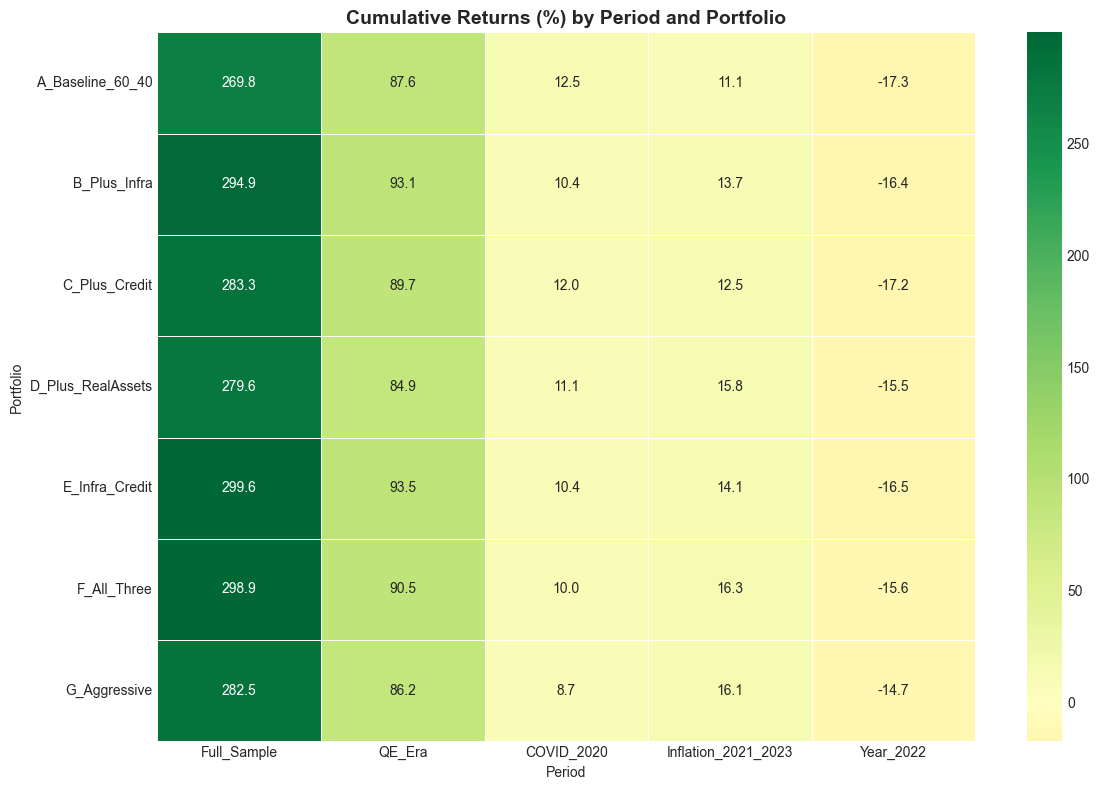

In [29]:
# Create pivot table for cumulative returns by period
if len(period_metrics) > 0:
    pivot_returns = period_metrics.pivot(index='Portfolio', columns='Period', values='Cumulative_%')
    
    # Reorder columns
    col_order = [c for c in PERIODS.keys() if c in pivot_returns.columns]
    pivot_returns = pivot_returns[col_order]
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.heatmap(pivot_returns, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                linewidths=0.5, ax=ax)
    
    ax.set_title('Cumulative Returns (%) by Period and Portfolio', fontsize=14, fontweight='bold')
    ax.set_xlabel('Period')
    ax.set_ylabel('Portfolio')
    
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for period analysis heatmap")

---
## 9. Results Summary & Conclusions

In [30]:
# Generate final summary
print("="*70)
print("BACKTESTING RESULTS SUMMARY")
print("="*70)
print(f"\nAnalysis Period: {analysis_returns.index[0].strftime('%Y-%m')} to {analysis_returns.index[-1].strftime('%Y-%m')}")
print(f"Total Months: {len(analysis_returns)}")
print()

# Rank portfolios by Sharpe ratio
ranking = metrics_df[['Ann_Return_%', 'Ann_Volatility_%', 'Sharpe_Ratio', 'Max_Drawdown_%']].copy()
ranking['Rank'] = ranking['Sharpe_Ratio'].rank(ascending=False).astype(int)
ranking = ranking.sort_values('Rank')

print("PORTFOLIO RANKINGS (by Sharpe Ratio):\n")
print(ranking.round(2))

# Improvement summary
baseline_sharpe = metrics_df.loc['A_Baseline_60_40', 'Sharpe_Ratio']
baseline_return = metrics_df.loc['A_Baseline_60_40', 'Ann_Return_%']
baseline_dd = metrics_df.loc['A_Baseline_60_40', 'Max_Drawdown_%']

print("\n" + "-"*70)
print("IMPROVEMENT VS 60/40 BASELINE:")
print("-"*70)
print(f"\nBaseline 60/40: Return={baseline_return:.2f}%, Sharpe={baseline_sharpe:.2f}, MaxDD={baseline_dd:.2f}%\n")

for col in ['B_Plus_Infra', 'E_Infra_Credit', 'F_All_Three', 'G_Aggressive']:
    ret_diff = metrics_df.loc[col, 'Ann_Return_%'] - baseline_return
    sharpe_diff = metrics_df.loc[col, 'Sharpe_Ratio'] - baseline_sharpe
    dd_diff = metrics_df.loc[col, 'Max_Drawdown_%'] - baseline_dd
    
    print(f"{col}:")
    print(f"  Return: {'+' if ret_diff > 0 else ''}{ret_diff:.2f}%")
    print(f"  Sharpe: {'+' if sharpe_diff > 0 else ''}{sharpe_diff:.3f}")
    print(f"  MaxDD:  {'+' if dd_diff > 0 else ''}{dd_diff:.2f}% {'(worse)' if dd_diff < 0 else '(better)'}")
    print()

BACKTESTING RESULTS SUMMARY

Analysis Period: 2010-10 to 2026-02
Total Months: 185

PORTFOLIO RANKINGS (by Sharpe Ratio):

                   Ann_Return_%  Ann_Volatility_%  Sharpe_Ratio  \
A_Baseline_60_40         8.8500            9.0200        0.8400   
C_Plus_Credit            9.1100            9.4400        0.8300   
E_Infra_Credit           9.4000           10.0900        0.8100   
B_Plus_Infra             9.3200            9.9900        0.8100   
F_All_Three              9.3900           10.6400        0.7800   
D_Plus_RealAssets        9.0400           10.3200        0.7700   
G_Aggressive             9.0900           10.7000        0.7500   

                   Max_Drawdown_%  Rank  
A_Baseline_60_40         -21.1300     1  
C_Plus_Credit            -21.2600     2  
E_Infra_Credit           -21.0400     3  
B_Plus_Infra             -20.9000     4  
F_All_Three              -20.7300     5  
D_Plus_RealAssets        -20.5500     6  
G_Aggressive             -20.0600     7  

---

### 9.2 Key Findings

In [31]:
# Determine best portfolio
best_sharpe_portfolio = metrics_df['Sharpe_Ratio'].idxmax()
best_return_portfolio = metrics_df['Ann_Return_%'].idxmax()
best_dd_portfolio = metrics_df['Max_Drawdown_%'].idxmax()  # Least negative

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

print(f"""
1. BEST RISK-ADJUSTED RETURNS (Sharpe Ratio):
   → {best_sharpe_portfolio}
   → Sharpe: {metrics_df.loc[best_sharpe_portfolio, 'Sharpe_Ratio']:.3f}

2. HIGHEST ABSOLUTE RETURNS:
   → {best_return_portfolio}
   → Return: {metrics_df.loc[best_return_portfolio, 'Ann_Return_%']:.2f}%

3. LOWEST DRAWDOWN:
   → {best_dd_portfolio}
   → Max DD: {metrics_df.loc[best_dd_portfolio, 'Max_Drawdown_%']:.2f}%

4. INFRASTRUCTURE IMPACT (Portfolio B vs A):
   → Return improvement: {metrics_df.loc['B_Plus_Infra', 'Ann_Return_%'] - baseline_return:.2f}%
   → Sharpe improvement: {metrics_df.loc['B_Plus_Infra', 'Sharpe_Ratio'] - baseline_sharpe:.3f}

5. DIVERSIFICATION BENEFIT:
   → Infrastructure correlation to Equity: {asset_correlation.loc['Infrastructure', 'Equity']:.2f}
   → Infrastructure correlation to Bonds: {asset_correlation.loc['Infrastructure', 'Bonds']:.2f}
""")


KEY FINDINGS

1. BEST RISK-ADJUSTED RETURNS (Sharpe Ratio):
   → A_Baseline_60_40
   → Sharpe: 0.843

2. HIGHEST ABSOLUTE RETURNS:
   → E_Infra_Credit
   → Return: 9.40%

3. LOWEST DRAWDOWN:
   → G_Aggressive
   → Max DD: -20.06%

4. INFRASTRUCTURE IMPACT (Portfolio B vs A):
   → Return improvement: 0.47%
   → Sharpe improvement: -0.029

5. DIVERSIFICATION BENEFIT:
   → Infrastructure correlation to Equity: 0.76
   → Infrastructure correlation to Bonds: 0.38



### 9.3 Limitations & Caveats

In [32]:
print("""
================================================================================
IMPORTANT LIMITATIONS & CAVEATS
================================================================================

1. PROXY LIMITATIONS:
   • Infrastructure (IGF): Listed infrastructure ETF, NOT private infrastructure
     - Higher volatility than true private infrastructure
     - Higher correlation to equity markets
   
   • Private Credit (HYG): High-yield bonds, NOT direct lending
     - Fixed rate (not floating like true private credit)
     - Different risk/return profile
   
   • Real Assets (GNR): Natural resource EQUITIES, NOT actual farmland/timberland
     - Much higher volatility than NCREIF indices
     - Higher correlation to equity markets

2. DATA LIMITATIONS:
   • ETF history limited (most start 2007-2011)
   • May not capture full GFC drawdown
   • Results may differ with institutional-quality indices

3. IMPLEMENTATION REALITY:
   • True private assets have:
     - 10-15 year lockups (vs. daily liquidity for ETFs)
     - Higher fees (2-4% vs. 0.3-0.5% for ETFs)
     - J-curve effects in early years
   • Backtest assumes instant rebalancing (not realistic for illiquid assets)

4. STATISTICAL CAVEATS:
   • Limited sample size for some periods
   • Past performance does not guarantee future results
   • Regime changes may alter correlations and returns

RECOMMENDATION:
   • Use these results as DIRECTIONAL GUIDANCE
   • Validate with institutional-quality data if available (NCREIF, EDHECinfra)
   • Apply conservative adjustments to ETF proxy results
""")


IMPORTANT LIMITATIONS & CAVEATS

1. PROXY LIMITATIONS:
   • Infrastructure (IGF): Listed infrastructure ETF, NOT private infrastructure
     - Higher volatility than true private infrastructure
     - Higher correlation to equity markets

   • Private Credit (HYG): High-yield bonds, NOT direct lending
     - Fixed rate (not floating like true private credit)
     - Different risk/return profile

   • Real Assets (GNR): Natural resource EQUITIES, NOT actual farmland/timberland
     - Much higher volatility than NCREIF indices
     - Higher correlation to equity markets

2. DATA LIMITATIONS:
   • ETF history limited (most start 2007-2011)
   • May not capture full GFC drawdown
   • Results may differ with institutional-quality indices

3. IMPLEMENTATION REALITY:
   • True private assets have:
     - 10-15 year lockups (vs. daily liquidity for ETFs)
     - Higher fees (2-4% vs. 0.3-0.5% for ETFs)
     - J-curve effects in early years
   • Backtest assumes instant rebalancing (not realist

---
## 10. Export Results

In [33]:
# Create output directory
import os
os.makedirs('./output', exist_ok=True)

# Export data
monthly_returns.to_csv('./output/monthly_returns_all_assets.csv')
portfolio_returns.to_csv('./output/portfolio_returns.csv')
metrics_df.to_csv('./output/performance_metrics.csv')
asset_correlation.to_csv('./output/correlation_matrix.csv')
quality_summary.to_csv('./output/data_quality_summary.csv')

if len(period_metrics) > 0:
    period_metrics.to_csv('./output/period_metrics.csv', index=False)

print("Results exported to ./output/ directory:")
print("  • monthly_returns_all_assets.csv")
print("  • portfolio_returns.csv")
print("  • performance_metrics.csv")
print("  • correlation_matrix.csv")
print("  • data_quality_summary.csv")
print("  • period_metrics.csv")

Results exported to ./output/ directory:
  • monthly_returns_all_assets.csv
  • portfolio_returns.csv
  • performance_metrics.csv
  • correlation_matrix.csv
  • data_quality_summary.csv
  • period_metrics.csv


---
## Next Steps

1. **Validate with Better Data:**
   - Obtain NCREIF Timberland/Farmland indices
   - Obtain Cliffwater Direct Lending Index
   - Obtain EDHECinfra for unlisted infrastructure

2. **Sensitivity Analysis:**
   - Test different weight combinations
   - Apply volatility adjustments to proxies
   - Test different rebalancing frequencies

3. **Present Findings:**
   - Prepare board presentation
   - Document methodology and limitations
   - Recommend implementation approach